<a href="https://colab.research.google.com/github/domarps/neural-net-notepad/blob/master/ResNet_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import ast
from scipy import ndimage, misc
import matplotlib.pyplot as plt
import cv2     
import sys
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import io
import requests
from PIL import Image

In [0]:
### Adapted from : https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/

### Load ImageNet class directory

In [0]:
import json, urllib.request
class_idx = json.loads(urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read().decode())
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

### Pretrained **ResNet50** initialization and forward pass definitions

In [0]:
class ResNetFeat(nn.Module):
  def __init__(self):
    super(ResNetFeat, self).__init__()
    self.resnet50_pretrained = models.resnet50(pretrained=True)
    for param in self.resnet50_pretrained.parameters():
      param.requires_grad = False
    conv_modules = list(self.resnet50_pretrained.children())[:-2] #all layers expect Adaptive AvgPool2D and FC
    pool_modules = [list(self.resnet50_pretrained.children())[-2]] # AvgPool2D
    fc_modules = [list(self.resnet50_pretrained.children())[-1]] # FC
    self.model_conv = nn.Sequential(*conv_modules)
    self.pool = nn.Sequential(*pool_modules)
    self.fc = nn.Sequential(*fc_modules)
    self.fc_weights = self.resnet50_pretrained.fc.weight
  
  def forward(self, image):
    feat2d = self.model_conv(image)
    featedpooled = self.pool(feat2d)
    # flatten the feature before feeding the fc.
    featdense = featedpooled.view(featedpooled.size(0), -1)
    pred_vec = self.fc(featdense)
    return feat2d, pred_vec

### Preprocessing Image

In [0]:
IMG_URL = 'https://as1.ftcdn.net/jpg/00/86/76/04/500_F_86760419_NEhOeuriYu82RwfgDqjTeIL9yx7ih5iv.jpg'
response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))

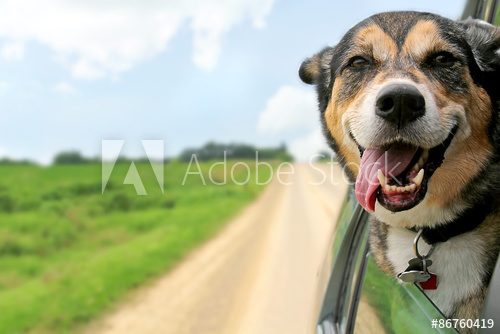

In [188]:
img_pil

In [0]:
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor() # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]

In [191]:
img = normalize(to_tensor(scaler(img_pil))).unsqueeze(0)
img.shape

torch.Size([1, 3, 224, 224])

### Forward Pass

In [155]:
featurizer = ResNetFeat()
last_conv_output, pred_vec = featurizer(img)
print(last_conv_output.shape, pred_vec.shape)

torch.Size([1, 2048, 7, 7]) torch.Size([1, 1000])


In [0]:
# bilinear upsampling to resize each filtered image to size of original image 
mat_for_mult = ndimage.zoom(torch.squeeze(last_conv_output).permute(2,1,0), (32, 32, 1), order=1) # dim: 224 x 224 x 2048

In [0]:
# get model's prediction (number between 0 and 999, inclusive)
pred = np.argmax(pred_vec)

In [181]:
# get layer weights
layer_weights = featurizer.fc_weights[pred, :]
layer_weights.shape

torch.Size([2048])

In [0]:
# get class activation map
CAM = np.dot(mat_for_mult.reshape((224*224, 2048)), layer_weights).reshape(224,224) # dim: 224 x 224

Text(0.5, 1.0, 'tennis_ball')

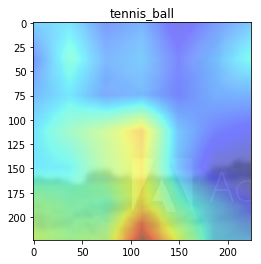

In [184]:
fig, ax = plt.subplots()
ax.imshow(img_pil, alpha=0.5)
ax.imshow(CAM, cmap='jet', alpha=0.5)
ax.set_title(idx2label[pred])   